## 🔗 Workflow Overview

This TIMM-based image classification pipeline is organized into three modular notebooks:

1. **`TIMM_Install&Train.ipynb`**  
   Sets up the environment and trains a baseline model using the Imagenette dataset. This is a good entry point for verifying model architecture, training loop, and basic setup.

2. **`TIMM_CustomedTrain.ipynb`**  
   Demonstrates how to apply TIMM models to a custom image classification dataset. Useful for adapting the training logic to datasets with different class definitions or distributions.

3. **`TIMM_Validate&Inference.ipynb`**  
   Focuses on evaluating trained models and running inference on new images. This notebook assumes a pretrained model is available and provides insights into accuracy and deployment use cases.

➡️ Each notebook is self-contained but follows a logical order. You can run them independently after setting the correct paths and prerequisites.

# Notebook: Customized Training with TIMM

This notebook uses the **Cassava Leaf Disease** dataset, located at `../dataset/cassavaleafdata`.

**Objective:** It demonstrates how to list models from TIMM and perform training using a selected architecture.

**Dataset Background**: The Cassava Leaf Disease dataset consists of labeled images of cassava leaves affected by diseases such as **cassava mosaic disease, cassava brown streak disease**, and **bacterial blight**, along with healthy samples. It is commonly used in **agricultural AI research**, especially in the context of **automated plant disease diagnosis**. The dataset supports real-world applications like improving crop yield, reducing human diagnosis errors, and enabling rapid disease detection in developing regions where cassava is a key food source.


🔗 [License and dataset link](https://www.kaggle.com/competitions/cassava-leaf-disease-classification)

---

In [1]:
%cd ./pytorch-image-models

/home/z890/timm/pytorch-image-models


/home/z890/.conda/envs/py310timm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
# according to previous kaggle user experiences, seresnext is a good choice of model for this task
import timm
import torch
model_names = [m for m in timm.list_models() if 'seresnext' in m]
print(model_names)

['legacy_seresnext26_32x4d', 'legacy_seresnext50_32x4d', 'legacy_seresnext101_32x4d', 'seresnext26d_32x4d', 'seresnext26t_32x4d', 'seresnext26ts', 'seresnext50_32x4d', 'seresnext101_32x4d', 'seresnext101_32x8d', 'seresnext101_64x4d', 'seresnext101d_32x8d', 'seresnextaa101d_32x8d', 'seresnextaa201d_32x8d']


In [3]:
# this time, we activate the Albumentations augmentation with '--no-aug' and use display card 1 with '--device 'cuda:1' 

In [3]:
%run ./train.py ../dataset/cassavaleafdata --model seresnext101d_32x8d --num-classes 5 --batch-size 16 --input-size 3 384 384 --epochs 10 --no-aug --device 'cuda:0'

Training with a single process on 1 device (cuda:0).
Model seresnext101d_32x8d created, param count:91549525
Data processing configuration for current model + dataset:
	input_size: (3, 384, 384)
	interpolation: bicubic
	mean: (0.485, 0.456, 0.406)
	std: (0.229, 0.224, 0.225)
	crop_pct: 0.95
	crop_mode: center
Learning rate (0.00625) calculated from base learning rate (0.1) and effective global batch size (16) with linear scaling.
Created SGD (sgd) optimizer: lr: 0.00625, momentum: 0.9, dampening: 0, weight_decay: 2e-05, nesterov: True, maximize: False, foreach: None, differentiable: False, fused: None
AMP not enabled. Training in torch.float32.
Scheduled epochs: 10 (epochs + cooldown_epochs). Warmup within epochs when warmup_prefix=False. LR stepped per epoch.
Train: 0 [   0/353 (  0%)]  Loss: 1.58 (1.58)  Time: 1.934s,    8.27/s  (1.934s,    8.27/s)  LR: 1.000e-05  Data: 0.165 (0.165)
Train: 0 [  50/353 ( 14%)]  Loss: 1.58 (1.59)  Time: 0.168s,   94.99/s  (0.200s,   80.08/s)  LR: 1.00

--result
[
    {
        "epoch": 4,
        "train": {
            "loss": 1.2118021779965409
        },
        "validation": {
            "loss": 1.3906145066795934,
            "top1": 43.2503970354685,
            "top5": 100.0
        }
    },
    {
        "epoch": 0,
        "train": {
            "loss": 1.449049664624352
        },
        "validation": {
            "loss": 1.3408396979877721,
            "top1": 48.43832715722605,
            "top5": 100.0
        }
    },
    {
        "epoch": 3,
        "train": {
            "loss": 1.209091653567198
        },
        "validation": {
            "loss": 1.0885107741903666,
            "top1": 61.03758602435151,
            "top5": 100.0
        }
    },
    {
        "epoch": 2,
        "train": {
            "loss": 1.2059562836085096
        },
        "validation": {
            "loss": 1.0982794784060732,
            "top1": 61.30227633668608,
            "top5": 100.0
        }
    },
    {
        "epoch": 1,
  

In [5]:
#after training, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# tutorial for more customed settings by official 
If you are not interested in the customization details, you can move on to TIMM_Validate&Inference.ipynb

In [6]:
import torch
from timm.data.mixup import Mixup
from timm.data.dataset import ImageDataset
from timm.data.loader import create_loader

In [7]:
import torchvision
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# load dataset
def get_dataset_and_loader(mixup_args):
    mixup_fn = Mixup(**mixup_args)
    dataset = ImageDataset('./../dataset/cassavaleafdata')
    loader = create_loader(dataset,
                           input_size=(3,384,384),
                           batch_size=4,
                           is_training=True,
                           use_prefetcher=False)
    return mixup_fn, dataset, loader

In [9]:
# define preprocessing pipeline
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
# set augmentation methods
mixup_args = {
    'mixup_alpha': 1.,
    'cutmix_alpha': 0.,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': 1000}

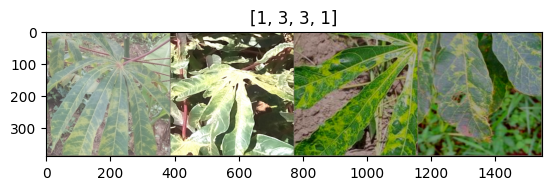

In [11]:
# run samples
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

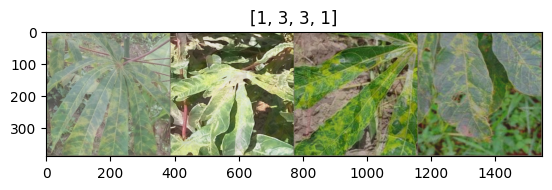

In [12]:
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])

In [13]:
mixup_args = {
    'mixup_alpha': 0.,
    'cutmix_alpha': 1.0,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.,
    'mode': 'batch',
    'label_smoothing': 0,
    'num_classes': 1000}

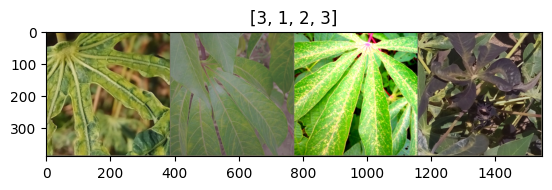

In [14]:
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

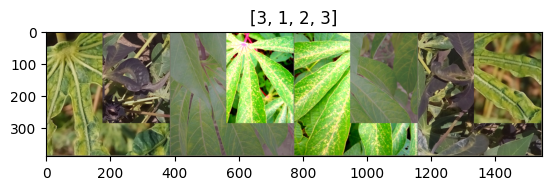

In [15]:
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])

In [16]:
def mixup(x, lam):
    """Applies mixup to input batch of images `x`

    Args:
    x (torch.Tensor): input batch tensor of shape (bs, 3, H, W)
    lam (float): Amount of MixUp
    """
    x_flipped = x.flip(0).mul_(1-lam)
    x.mul_(lam).add_(x_flipped)
    return x

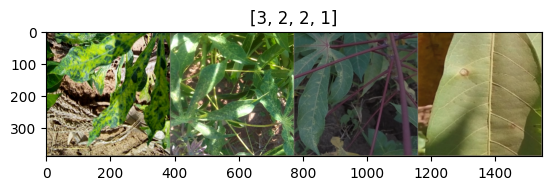

In [17]:
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

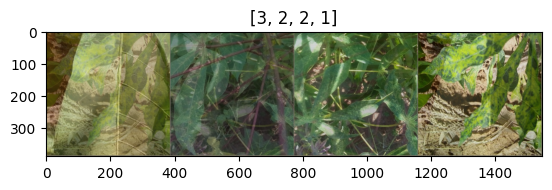

In [18]:
imshow(
    torchvision.utils.make_grid(
        mixup(inputs, 0.3)
    ),
    title=[x.item() for x in classes])

In [19]:
mixup_args = {
    'mixup_alpha': 0.3,
    'cutmix_alpha': 0.3,
    'cutmix_minmax': None,
    'prob': 1.0,
    'switch_prob': 0.5,
    'mode': 'elem',
    'label_smoothing': 0,
    'num_classes': 1000}

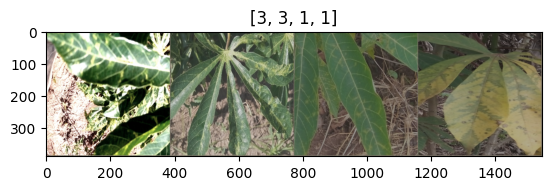

In [20]:
mixup_fn, dataset, loader = get_dataset_and_loader(mixup_args)
inputs, classes = next(iter(loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

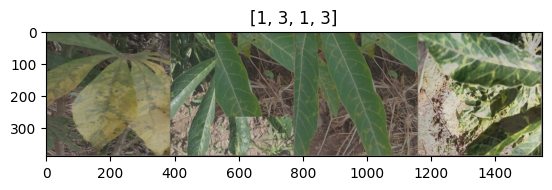

In [21]:
inputs, classes = mixup_fn(inputs, classes)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes.argmax(1)])

In [22]:
!pwd

/home/z890/timm/pytorch-image-models


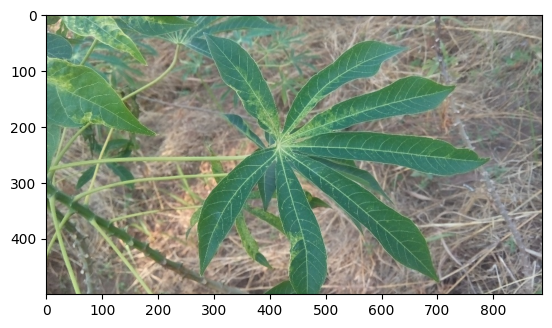

In [23]:
# see how augmentation be like
from timm.data.auto_augment import rand_augment_transform
from PIL import Image
from matplotlib import pyplot as plt

tfm = rand_augment_transform(
    config_str='rand-m9-mstd0.5',
    hparams={'translate_const': 117, 'img_mean': (124, 116, 104)}
)

x   = Image.open("../dataset/cassavaleafdata/train/cmd/train-cmd-3.jpg")
plt.imshow(x)

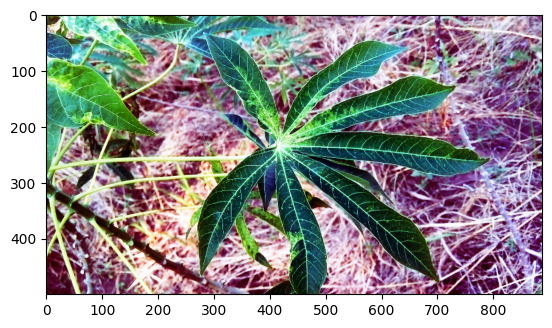

In [24]:
plt.imshow(tfm(x))

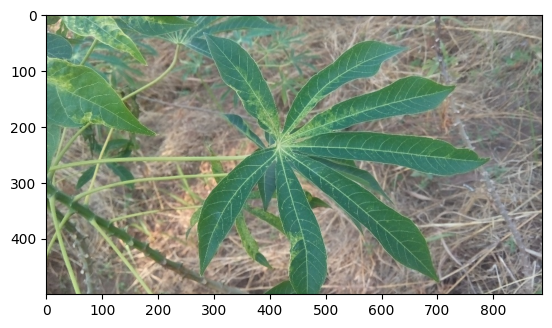

In [25]:
from PIL import Image
from timm.data.random_erasing import RandomErasing
from torchvision import transforms
from matplotlib import pyplot as plt

img = Image.open("../dataset/cassavaleafdata/train/cmd/train-cmd-3.jpg")
x   = transforms.ToTensor()(img)
plt.imshow(x.permute(1, 2, 0))

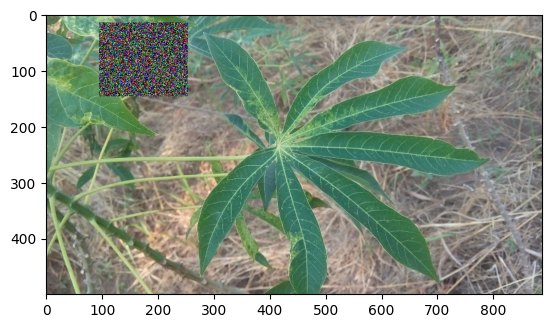

In [26]:
random_erase = RandomErasing(probability=1, mode='pixel', device='cpu')
plt.imshow(random_erase(x).permute(1, 2, 0))